In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time

#from P6_00_Functions import *
from sklearn import metrics
from scipy.stats import loguniform
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from matplotlib.colors import ListedColormap
#cmap = ListedColormap(['#4cb2ff', '#61ba86'])

# Scénario
Votre société de consulting informatique vous propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. Votre mission si vous l'acceptez : créer un algorithme de détection de faux billets.

Vous vous voyez déjà en grand justicier combattant sans relâche la criminalité organisée en pianotant à mains de maître votre ordinateur, pour façonner ce fabuleux algorithme  qui traquera la moindre fraude et permettra de mettre à jour les réseaux secrets de faux-monnayeurs ! La classe, non ?

... Bon, si on retombait les pieds sur terre? Travailler pour la police judiciaire, c'est bien, mais vous allez devoir faire appel à vos connaissances en statistiques, alors on y va !

# Les données
La PJ vous transmet un jeu de données contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

   1. la longueur du billet (en mm) ;
   2. la hauteur du billet (mesurée sur le côté gauche, en mm) ;
   3. La hauteur du billet (mesurée sur le côté droit, en mm) ;
   4. la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
   5. la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
   6. la diagonale du billet (en mm).
   
# Votre mission


# Mission 0
Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).

In [23]:
df = pd.read_csv('datas/notes.csv' , header=0, sep=",", decimal=".")
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [24]:
df.shape

(170, 7)

In [25]:
df.describe(include = 'all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,NaN,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,NaN,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,NaN,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,NaN,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,NaN,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [27]:
df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [28]:
print(df.duplicated().sum())


0


Le calcul de la distribution empirique est la première étape pour la représentation graphique d'une variable qualitative.


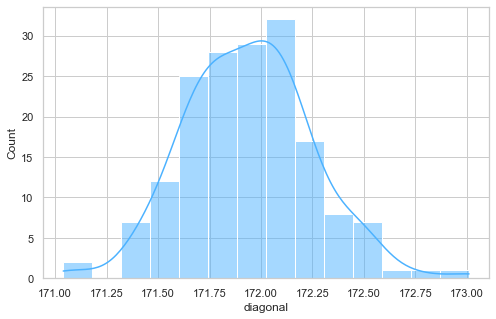

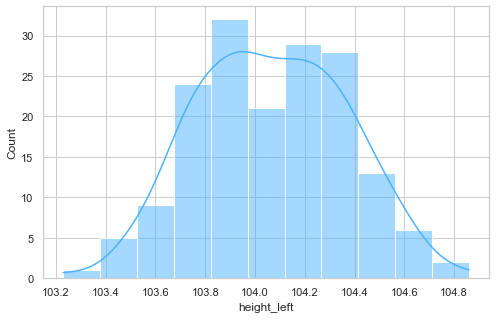

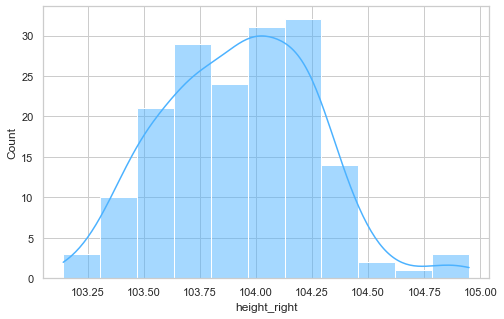

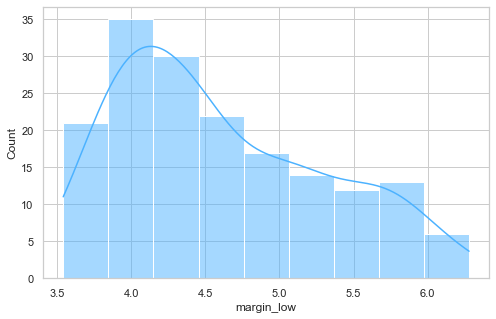

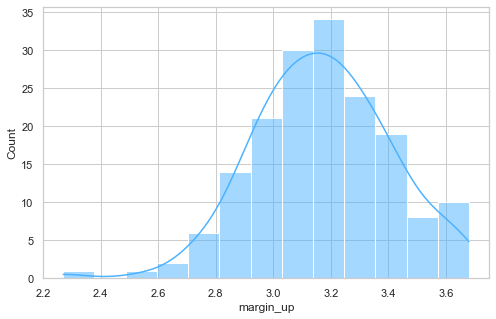

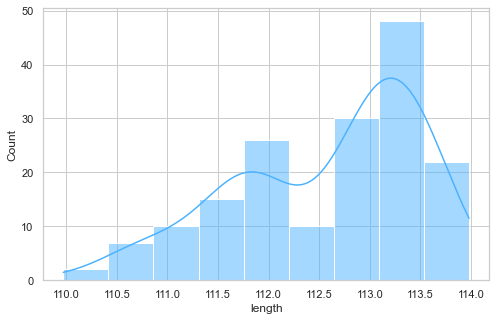

In [29]:
for column in df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']] :
    plt.figure(figsize = (8,5))
    sns.histplot(x=column, data=df, kde=True, color='#4cb2ff')
    plt.xlabel(column)

In [32]:
#normality of variables in df
import pingouin as pg
pg.normality(df, method='shapiro', alpha=0.05).drop('is_genuine')

#normality: test de normalité univarié.

,W,pval,normal
diagonal,0.993177,6.106325e-01,True
height_left,0.992723,5.533670e-01,True
height_right,0.988121,1.625284e-01,True
margin_low,0.935401,6.225721e-07,False
margin_up,0.988917,2.044352e-01,True
length,0.932463,3.714225e-07,False


# Mission 1
Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

analyse de l'éboulis des valeurs propres ;
représentation des variables par le cercle des corrélations ;
représentation des individus par les plans factoriels ;
analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

# Mission 2
Appliquez un algorithme de classification, puis analysez le résultat obtenu.

Visualisez la partition obtenue dans le premier plan factoriel de l'ACP, puis analysez-la.

# Mission 3
Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.